# HyDE

https://ar5iv.labs.arxiv.org/html/2212.10496

In [1]:
from datasets import load_dataset
import pandas as pd
import torch

dataset = load_dataset("msaad02/categorized-data", split="train")
category_df = dataset.to_pandas()

qa_dataset = load_dataset("msaad02/brockport-gpt-4-qa", split="train")
qa_df = qa_dataset.to_pandas()

df = pd.merge(qa_df, category_df[["url", "category", "subcategory"]], on="url", how="left")

train_df = df.groupby("category").sample(n=2000, replace=True)
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [2]:
df['category'].value_counts()

category
academics              6073
live                   1465
life                   1361
support                 808
about                   615
alumni                  415
graduate                256
admissions              232
scholarships-aid        141
library                  90
research-foundation      85
bsg                      36
Name: count, dtype: int64

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(lowercase=True, min_df=5)

train_vect = vectorizer.fit_transform(train_df['question'])

In [4]:
text_to_int = {text: idx for idx, text in enumerate(train_df['category'].unique())}
int_to_text = {idx: text for text, idx in text_to_int.items()}

train_df['category_vect'] = train_df['category'].apply(lambda x: text_to_int[x])

In [5]:
train_proportion = 0.8
validation_prop = 0.1
train_size = int(train_proportion * train_vect.shape[0])
validation_size = int(validation_prop * train_vect.shape[0])

X_train = torch.tensor(train_vect[:train_size].toarray(), dtype=torch.float32)
y_train = torch.tensor(train_df['category_vect'][:train_size].to_numpy(), dtype=torch.long)
X_val = torch.tensor(train_vect[train_size:train_size+validation_size].toarray(), dtype=torch.float32)
y_val = torch.tensor(train_df['category_vect'][train_size:train_size+validation_size].to_numpy(), dtype=torch.long)
X_test = torch.tensor(train_vect[train_size+validation_size:].toarray(), dtype=torch.float32)
y_test = torch.tensor(train_df['category_vect'][train_size+validation_size:].to_numpy(), dtype=torch.long)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
# Hyper-parameters
input_size = X_train.shape[1]
hidden_size = 10000
num_classes = train_df['category'].unique().__len__()
num_epochs = 200

# Instantiate the model, optimizer, and loss function
model = SimpleNN(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

train_losses = []
validation_losses = []

# Train the model
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Validation loss
    validation_loss = criterion(model(X_val), y_val)

    train_losses.append(loss.detach().numpy())
    validation_losses.append(validation_loss.detach().numpy())

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {validation_loss.item():.4f}')

Epoch [10/200], Loss: 2.3783, Validation Loss: 2.3835
Epoch [20/200], Loss: 2.2430, Validation Loss: 2.2537
Epoch [30/200], Loss: 2.0656, Validation Loss: 2.0831
Epoch [40/200], Loss: 1.8346, Validation Loss: 1.8602
Epoch [50/200], Loss: 1.5605, Validation Loss: 1.5952
Epoch [60/200], Loss: 1.2787, Validation Loss: 1.3231
Epoch [70/200], Loss: 1.0290, Validation Loss: 1.0830
Epoch [80/200], Loss: 0.8309, Validation Loss: 0.8933
Epoch [90/200], Loss: 0.6823, Validation Loss: 0.7511
Epoch [100/200], Loss: 0.5723, Validation Loss: 0.6458
Epoch [110/200], Loss: 0.4900, Validation Loss: 0.5669
Epoch [120/200], Loss: 0.4271, Validation Loss: 0.5068
Epoch [130/200], Loss: 0.3779, Validation Loss: 0.4600
Epoch [140/200], Loss: 0.3386, Validation Loss: 0.4227
Epoch [150/200], Loss: 0.3065, Validation Loss: 0.3926
Epoch [160/200], Loss: 0.2798, Validation Loss: 0.3678
Epoch [170/200], Loss: 0.2574, Validation Loss: 0.3472
Epoch [180/200], Loss: 0.2382, Validation Loss: 0.3299
Epoch [190/200], Lo

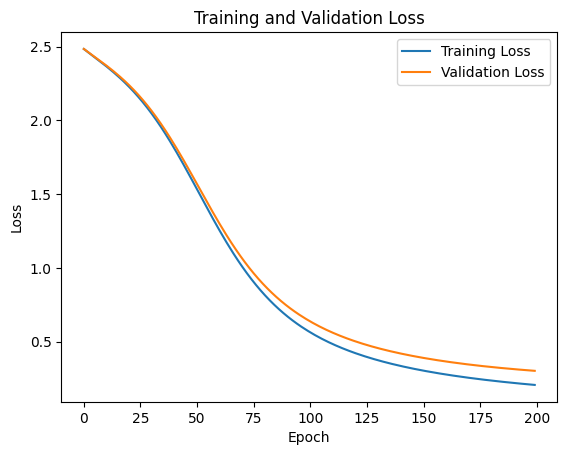

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the training and validation loss
plt.plot(np.array(train_losses), label='Training Loss')
plt.plot(np.array(validation_losses), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [8]:
# Find the paramter count of the model
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')

25,420,012 total parameters.


In [9]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

# Evaluate the model on the test data
with torch.no_grad():
    model.eval()
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, predicted)
print("Confusion Matrix:")
print(confusion_mat)


Accuracy: 92.92%
Confusion Matrix:
[[190   0   0   0   0   6   0   0   0   0   0   2]
 [  0 170   0   1   3   0   8   1   2   2   2  10]
 [  0   1 216   1   0   0   0   0   0   0   1   3]
 [  0   0   0 187   0   0   0   0   0   0   2   0]
 [  2   3   0   0 191   3   1   0   1   0   1   5]
 [  6  10   3   0  11 162   5   0   0   2   7   6]
 [  0   9   0   1   6   1 162   0   0   1   3   4]
 [  0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0 185   0   3   0]
 [  0   0   0   0   0   0   0   0   0 205   0   0]
 [  0   0   2   0   1   0   4   0   2   0 219   0]
 [  0   4   1   0   6   4   0   2   2   0   3 166]]


In [10]:
import json
def predict_category(question: str):
    question_vect = vectorizer.transform([question])
    question_vect = torch.tensor(question_vect.toarray(), dtype=torch.float32)
    with torch.no_grad():
        model.eval()
        outputs = model(question_vect)
        _, predicted = torch.max(outputs.data, 1)

    label_softmax = torch.softmax(outputs, dim=1).detach().numpy()[0]
    probability_dict = {int_to_text[idx]: round(prob*100, 2) for idx, prob in enumerate(label_softmax)}

    return_string = f"""\
    Predicted Category: {int_to_text[predicted.item()]}

    Probability Distribution:
    {json.dumps(probability_dict, indent=4)}
    """
    return return_string

In [11]:
import gradio as gr

demo = gr.Interface(fn=predict_category, inputs="text", outputs="text")
    
if __name__ == "__main__":
    demo.launch(show_api=False)   

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
